# Prepare data

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import os, sys

def find_src_dir(start_path=None):
    """
    从 start_path 开始往上依次查找，直到根目录都没找到就报错。
    找到某层目录下有个 src 子文件夹就返回它的绝对路径。
    """
    if start_path is None:
        start_path = os.getcwd()
    path = start_path
    while True:
        candidate = os.path.join(path, "src")
        if os.path.isdir(candidate):
            return candidate
        parent = os.path.dirname(path)
        if parent == path:  # 已经到根目录了
            break
        path = parent
    raise FileNotFoundError(f"找不到 src 目录，已搜索到 {start_path} 的所有父级路径")

# 找到 src 并插入到 sys.path
try:
    SRC_PATH = find_src_dir()
    sys.path.insert(0, SRC_PATH)
    print("✅ 已将 src 添加到模块搜索路径：", SRC_PATH)
except FileNotFoundError as e:
    print("❌", e)

# 现在再试 import
from preprocess import *
#from tf_models import *
from torch_models import *

from pytorch_models import *

print("✅ import 成功！")

✅ 已将 src 添加到模块搜索路径： /Users/liujinxian/Desktop/NewNeworkForecast/ICC26/src
✅ import 成功！


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker
base_dir = ".."

In [16]:
#file_name = f"{base_dir}/Processed_Dataset/CERNET_15min.csv"  # the input filename
file_name = f"{base_dir}/data/processed/CERNET.csv"  # the input filename
#file_name = f"{base_dir}/Processed_Dataset/Abilene_15min.csv"  # the input filename

In [17]:
df = pd.read_csv(file_name)
df = df.set_index('date')
df = df.dropna()
df = df.loc['2004-05-01':]
print(np.isnan(df).any(), np.isnan(df).any())

data    False
dtype: bool data    False
dtype: bool


In [18]:

# 1. Make sure the date index is a column, and rename it to "ds":
df = df.reset_index().rename(columns={'date': 'ds'})
df['ds'] = pd.to_datetime(df['ds'])

# 2. Rename your value column to "y":
df = df.rename(columns={df.columns[-1]: 'y'})

# 3. Add a constant unique_id column (floats, to match your example):
df['unique_id'] = 1.0

# 4. Reorder columns:
df = df[['unique_id', 'ds', 'y']]

In [19]:
df

,unique_id,ds,y
0,1.0,2013-02-19 22:00:00,14961.012148
1,1.0,2013-02-19 23:00:00,12031.262185
2,1.0,2013-02-20 00:00:00,6400.142220
3,1.0,2013-02-20 01:00:00,3261.291051
4,1.0,2013-02-20 02:00:00,1978.597413
...,...,...,...
829,1.0,2013-03-26 11:00:00,31927.478640
830,1.0,2013-03-26 12:00:00,33363.036962
831,1.0,2013-03-26 13:00:00,34203.060161
832,1.0,2013-03-26 14:00:00,33638.139253


In [10]:
import logging

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)


/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-21 02:45:45,736	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-21 02:45:45,900	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [42]:
horizon = 180

# Try different hyperparmeters to improve accuracy.
models = [LSTM(input_size=2 * horizon,
               h=horizon,                    # Forecast horizon
               max_steps=500,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=2 * horizon,      # Length of input sequence
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='H')
nf.fit(df=df)


Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df
Y_hat_df.head()

Seed set to 1
Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s, v_num=53, train_loss_step=1.91e+3, train_loss_epoch=1.91e+3]


/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.94it/s]


,unique_id,ds,LSTM,NHITS
0,1.0,2013-03-26 16:00:00,32341.505859,32464.802734
1,1.0,2013-03-26 17:00:00,32885.343750,32843.941406
2,1.0,2013-03-26 18:00:00,33377.054688,33531.750000
3,1.0,2013-03-26 19:00:00,33710.171875,33609.527344
4,1.0,2013-03-26 20:00:00,33956.789062,34131.003906


In [ ]:
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, TCN

# 假设 df 原本已经有 unique_id、ds、y 三列
# 如果没有，先创建：df['unique_id'] = 1


lagged_value = 24
# 1. 切分 75%/12.5%/12.5%
n = len(df)
train_end = int(n * 0.75)
valid_end = train_end + int(n * 0.125)


train_df = df.iloc[:train_end].reset_index(drop=True)
valid_df = df.iloc[train_end:valid_end].reset_index(drop=True)
test_df  = df.iloc[valid_end:].reset_index(drop=True)

"""
# 2. 一步预测模型
model = LSTM(
    input_size=lagged_value,
    h=1,
    max_steps=500,
    scaler_type='standard',
    encoder_hidden_size=64,
    decoder_hidden_size=64,
)
"""

model = TCN(
    input_size=lagged_value,       # 滞后窗口大小
    h=1,                            # 一步预测
    kernel_size=3,                  # 卷积核大小
    dilations=[1, 2, 4],            # 膨胀系数
    encoder_hidden_size=64,         # 隐层通道数
    context_size=10,                # 上下文向量大小
    decoder_hidden_size=64,         # 解码器隐藏层大小
    decoder_layers=2,               # 解码器层数
    max_steps=500,                  # 训练迭代次数
    scaler_type='standard',         # 标准化
)


model_name = model.__class__.__name__


# 3. 先在 Train+Valid 上调参/早停
nf = NeuralForecast(models=[model], freq='h')
nf.fit(df=train_df)#, validation_df=valid_df)



# —— （这里你可以调整超参，再 repeat 上面的 train+validate 过程）


# —— 3. 在验证集上做滚动预测并算 MAPE
history = train_df.copy()
preds_valid = []

for _, row in valid_df.iterrows():
    window = history.iloc[-model.input_size:][['unique_id','ds','y']]
    y_hat_df = nf.predict(window)
    y_pred = y_hat_df.loc[y_hat_df.unique_id==row.unique_id, ].values[0]
    preds_valid.append(y_pred)
    history = pd.concat([history, pd.DataFrame([row])], ignore_index=True)

y_true_valid = valid_df['y'].values
mape_valid = np.mean(np.abs((y_true_valid - np.array(preds_valid)) / y_true_valid)) * 100

# —— 2. 在 训练集 上做滚动预测来算 MAPE
#    注意：要先保留前 input_size 条数据作“窗口种子”
history_train = train_df.iloc[:model.input_size].copy()
preds_train = []

for _, row in train_df.iloc[model.input_size:].iterrows():
    window = history_train.iloc[-model.input_size:][['unique_id','ds','y']]
    y_hat_df = nf.predict(window)
    y_pred = y_hat_df.loc[y_hat_df.unique_id==row.unique_id, 'LSTM'].values[0]
    preds_train.append(y_pred)
    # 把这一行真实值追加到 history_train
    history_train = pd.concat([history_train, pd.DataFrame([row])], ignore_index=True)

y_true_train = train_df['y'].values[model.input_size:]
mape_train = np.mean(np.abs((y_true_train - np.array(preds_train)) / y_true_train)) * 100

print(f"Validation MAPE: {mape_valid:.2f}%")
print(f"Training MAPE: {mape_train:.2f}%")

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2437867596.py, line 63)

In [72]:
# 4. 合并 Train+Valid 重训
combined_df = pd.concat([train_df, valid_df]).reset_index(drop=True)
nf_retrain = NeuralForecast(models=[model], freq='h')
nf_retrain.fit(df=combined_df)

# 5. 迭代预测 Test，记得带上 unique_id
history = combined_df.copy()
preds = []

for _, row in test_df.iterrows():
    # 取最近 input_size 行，并保留 unique_id, ds, y
    last_window = history.iloc[-model.input_size:][['unique_id','ds','y']]
    # 用这一小段做预测
    y_hat_df = nf_retrain.predict(last_window)
    # 取这一条 series 的预测值
    next_val = y_hat_df[y_hat_df['unique_id']==row['unique_id']]['LSTM'].values[0]
    preds.append(next_val)
    # 把真实观测接到 history
    history = pd.concat([history, pd.DataFrame([row])], ignore_index=True)

# preds 就是针对 test_df 按步迭代得到的预测序列

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.20it/s]


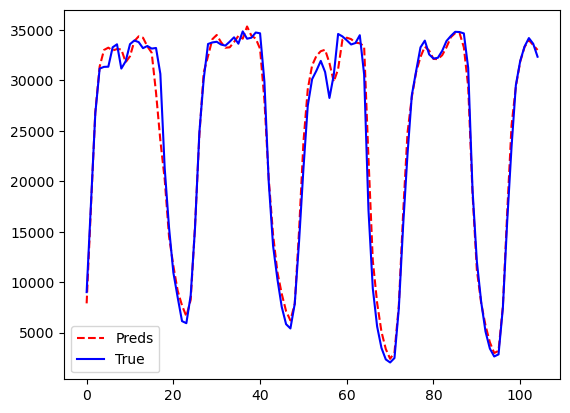

In [73]:
plt.plot(preds, 'r--',  label='Preds')     # b = blue
plt.plot(test_df['y'], 'b-', label='True')  # r = red, -- = 虚线
plt.legend()


In [74]:
import numpy as np

# 假设 preds 是你的预测列表，test_df['y'] 是对应的真实值
y_true = test_df['y'].values
y_pred = np.array(preds)

# 计算每一步的绝对百分比误差
ape = np.abs((y_true - y_pred) / y_true)

# 平均并乘以 100 得到百分比
mape = np.mean(ape) * 100

print(f"MAPE: {mape:.2f}%")


MAPE: 6.65%


In [75]:
Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df
Y_hat_df.head()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.91it/s]


,unique_id,ds,LSTM
0,1.0,2013-03-17 23:00:00,32055.591797


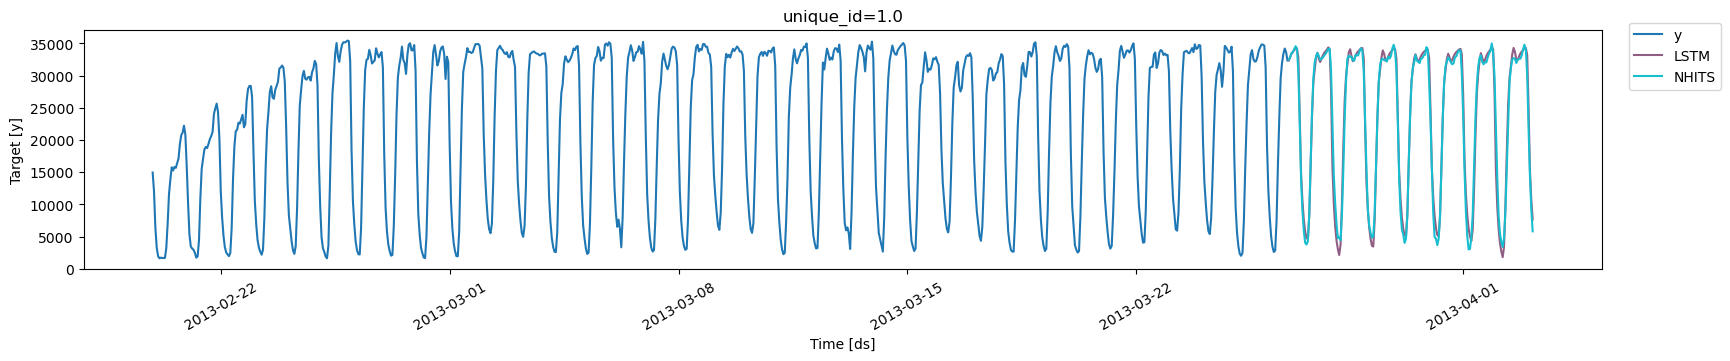

In [40]:
from utilsforecast.plotting import plot_series
plot_series(df, Y_hat_df)


# Temp Torch

## TimeMixer

/Users/liujinxian/Desktop/NewNeworkForecast/ICC26/src/pytorch_models.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647065806/work/torch/csrc/utils/tensor_new.cpp:281.)
  X = torch.tensor(X, dtype=torch.float32)


Epoch 1: Train Loss=1.1810, Val Loss=0.7583
Epoch 2: Train Loss=0.4454, Val Loss=0.2239
Epoch 3: Train Loss=0.1520, Val Loss=0.0797
Epoch 4: Train Loss=0.0749, Val Loss=0.0430
Epoch 5: Train Loss=0.0472, Val Loss=0.0309
Epoch 6: Train Loss=0.0384, Val Loss=0.0281
Epoch 7: Train Loss=0.0335, Val Loss=0.0265
Epoch 8: Train Loss=0.0309, Val Loss=0.0251
Epoch 9: Train Loss=0.0292, Val Loss=0.0240
Epoch 10: Train Loss=0.0279, Val Loss=0.0230
Epoch 11: Train Loss=0.0267, Val Loss=0.0221
Epoch 12: Train Loss=0.0257, Val Loss=0.0213
Epoch 13: Train Loss=0.0248, Val Loss=0.0205
Epoch 14: Train Loss=0.0240, Val Loss=0.0199
Epoch 15: Train Loss=0.0233, Val Loss=0.0193
Epoch 16: Train Loss=0.0226, Val Loss=0.0188
Epoch 17: Train Loss=0.0220, Val Loss=0.0184
Epoch 18: Train Loss=0.0215, Val Loss=0.0179
Epoch 19: Train Loss=0.0210, Val Loss=0.0176
Epoch 20: Train Loss=0.0205, Val Loss=0.0172
Epoch 21: Train Loss=0.0200, Val Loss=0.0170
Epoch 22: Train Loss=0.0196, Val Loss=0.0167
Epoch 23: Train Los

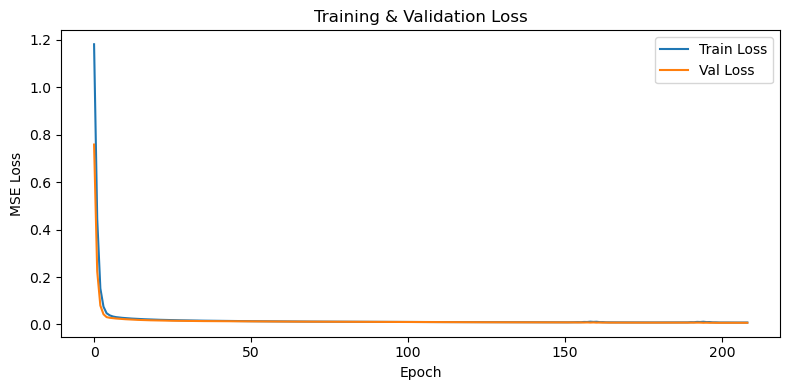

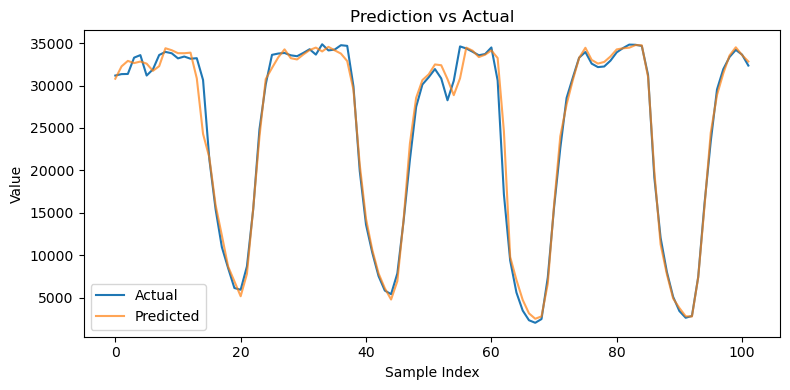

In [7]:
# 示範執行流程
values_raw = extract_values(df)
lag = 24
n_train, n_val, n_test = split_indices(len(values_raw), lag)
scaler = fit_scaler(values_raw, lag, n_train)
values = transform_values(values_raw, scaler)
X, y = create_sequences(values, lag)
train_loader, val_loader, test_loader = get_dataloaders(X, y, n_train, n_val)


#model = TCN(num_inputs=1, num_channels=[25,25], kernel_size=3, dropout=0.2)
model = FeedforwardNN(input_size=lag, hidden_size=50)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model, history = train_model(model, train_loader, val_loader, criterion, optimizer)
preds, acts = evaluate_model(model, test_loader, scaler)
metrics = compute_metrics(preds, acts)
print(metrics)

plot_loss(history)
plot_predictions(acts, preds)